In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import yaml
import tqdm
import json
import torch
import hydra
import pprint
import logging
import colorlog
import src.prepare  # noqa
import logging.config

import numpy as np
import pytorch_lightning as pl

from src.config import read_config
from hydra.utils import instantiate
from src.load import load_model_from_cfg
from omegaconf import OmegaConf, DictConfig
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

/home/nadir/tmr-code/.tmr.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
LOGGING_CONFIG = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'simple': {
            'format': '[%(asctime)s][%(name)s][%(levelname)s] - %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
        },
        'colorlog': {
            '()': 'colorlog.ColoredFormatter',
            'format': '[%(white)s%(asctime)s%(reset)s] %(log_color)s%(levelname)s%(reset)s   %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
            'log_colors': {
                'DEBUG': 'purple',
                'INFO': 'blue',
                'WARNING': 'yellow',
                'ERROR': 'red',
                'CRITICAL': 'red',
            },
        },
    },
}

logging.config.dictConfig(LOGGING_CONFIG)

logger = logging.getLogger(__name__)

logger.info("logger has been configured.")

In [13]:
RUN_DIRS = [
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_20",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_25",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_30",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_35",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_40",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_45",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_50",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_20",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_25",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_30",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_35",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_40",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_45",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_False_mlp_50",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_20",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_25",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_30",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_35",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_40",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_45",
    "/home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_tmr_True_mlp_50"
]

In [14]:
def load_segmentation_metrics(output_path):
    """Load segmentation evaluation metrics from JSON file"""
    metrics_path = os.path.join(output_path, "segmentation-evaluation", "metrics.json")
    
    try:
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                return json.load(f)
    except Exception as e:
        print(f"Error loading metrics from {output_path}: {e}")
    return None

def parse_model_info(output_path):
    """Parse model information from output path"""
    parts = os.path.basename(output_path).split('_')
    encoder_type = parts[1]  # stgcn or tmr
    pretrained = parts[2] == 'True'
    window_size = int(parts[4])
    
    if encoder_type == 'stgcn':
        model_name = "ST-GCN"
    elif encoder_type == 'tmr' and not pretrained:
        model_name = "TMR (no pretraining)"
    else:  # tmr with pretraining
        model_name = "TMR (with pretraining)"
    
    return model_name, window_size

In [15]:
def get_config(index: int):
    with initialize(
        version_base=None,
        config_path="configs",
        # 
    ):
        # config = compose(overrides=["+db=mysql"])
        config = compose(
            config_name="evaluate-start-end-segmentation-segmenter",
            return_hydra_config=True,
            overrides=[f"run_dir={RUN_DIRS[index]}"]
        )
        
        from hydra.core.hydra_config import HydraConfig
        
        HydraConfig.instance().set_config(config)
        
        return config

In [16]:
def prepare(config, with_seeding=True, pretrained=True):
    device = config.device
    run_dir = config.run_dir
    examples = config.examples
    ckpt_name = config.ckpt

    save_dir = os.path.join(run_dir, "segmentation-evaluation")
    os.makedirs(save_dir, exist_ok=True)
    
    print("[config.data]:", config.data)
    
    window_size = int(run_dir.split("_mlp_")[1])

    # NOTE: moved up here in order to use the segmentation config for the dataset
    # defined in the config file rather than the config used to train the model
    dataset = instantiate(
        config.data,
        dir="/home/nadir/disk/datasets/babel-for-validation",
        window_size=window_size,
        split="all",
        for_validation=True,
        normalize=False,
    )
    
    normalization_statistics = torch.load(os.path.join(dataset.dir, "motion_normalization_stats.pt"))

    mean = normalization_statistics["mean"]
    std = normalization_statistics["std"]
    
    print("[mean.shape]:", mean.shape)
    print("[std.shape]:", std.shape)

    # NOTE: will load the config used to train the model
    
    cfg = read_config(run_dir)

    pl.seed_everything(cfg.seed)

    logger.info("[model]: loading")
    model = load_model_from_cfg(cfg, ckpt_name, eval_mode=True, device=device, pretrained=pretrained)

    model = model.eval()
    
    return model, dataset, device, window_size, mean, std

In [17]:
# config = get_config(18)
config = get_config(4)
# config = get_config(2)

metrics = load_segmentation_metrics(config.run_dir)

print("[config.run_dir]:", config.run_dir)
print("[metrics]:", metrics)

model, dataset, device, window_size, mean, std = prepare(config, pretrained=True)

print("[#dataset]:", len(dataset))

Global seed set to 1234


[config.run_dir]: /home/nadir/tmr-code/outputs/archives/snapshot-06-02-16:30/start-end-segmentation_stgcn_False_mlp_40
[metrics]: {'framewise_accuracy': 0.7621569405453676, 'edit_score': 0.7651706095200113, 'f1_scores': {'f1@0.10': 0.6603825840469434, 'f1@0.20': 0.615270252578462, 'f1@0.30': 0.5765571707735224, 'f1@0.40': 0.5480669932665598, 'f1@0.50': 0.5165402440375978, 'f1@0.60': 0.48890871919347767, 'f1@0.70': 0.4568678212568927, 'f1@0.80': 0.4258077881199871, 'f1@0.90': 0.3860288800315932, 'f1@1.00': 0.3495424804581183}, 'balanced_accuracy': 0.6184430357883799, 'matthews_corrcoef': 0.17033563098183793, 'per_class': {'0.0': {'precision': 0.9269705781059956, 'recall': 0.7972098498822753, 'f1': 0.8572073588370345}, '1.0': {'precision': 0.19551119969063271, 'recall': 0.4396762216944844, 'f1': 0.2706653900402549}}}
[config.data]: {'_target_': 'src.data.windowed_dataset.WindowedDataset', 'dir': '???', 'window_size': '???', 'preload': False, 'normalize': False}
[mean.shape]: torch.Size([

In [18]:
import json
import pandas as pd

amass_to_hml3d_path = "/home/nadir/code/babel/amass-to-hml3d.csv"
amass_to_babel_path = "/home/nadir/code/babel/amass-to-babel.json"

def find_amass_in_hml3d_not_in_babel(csv_path, json_path):
    df = pd.read_csv(csv_path)
    hml3d_paths = df['source_path'].apply(lambda x: x.replace('./pose_data/', '').replace('_poses.npy', '_poses'))
    hml3d_set = set(hml3d_paths)

    with open(json_path, 'r') as f:
        babel_data = json.load(f)
        
    babel_set = set(babel_data.keys())

    only_in_hml3d = sorted(hml3d_set - babel_set)

    return only_in_hml3d

missing_in_babel = find_amass_in_hml3d_not_in_babel(amass_to_hml3d_path, amass_to_babel_path)

print(f"[treatment]: found {len(missing_in_babel)} AMASS samples in HML3D but not in BABEL.")

print("[missing_in_babel]:", missing_in_babel[:10])

[treatment]: found 1810 AMASS samples in HML3D but not in BABEL.
[missing_in_babel]: ['ACCAD/Female1General_c3d/A12 - crawl backwards_poses', 'ACCAD/Female1Running_c3d/C25 -  side step right_poses', 'ACCAD/Female1Walking_c3d/B20 - walk with box_poses', 'ACCAD/Female1Walking_c3d/B21 s3 - put down box to walk_poses', 'ACCAD/Male1Walking_c3d/Walk B15 - Walk turn around_poses', 'ACCAD/Male1Walking_c3d/Walk B22 - Side step left_poses', 'ACCAD/Male2MartialArtsKicks_c3d/G17-  push kick left_poses', 'ACCAD/Male2MartialArtsPunches_c3d/E14 - body cross right_poses', 'ACCAD/Male2MartialArtsStances_c3d/D5 - ready to walk away_poses', 'ACCAD/Male2Running_c3d/C1 - stand to run_poses']


[hml3d_sample.keys()]: dict_keys(['file_id', 'amass_relative_path', 'motion', 'transformed_motion', 'annotations', 'index'])
[outputs.shape]: torch.Size([199])
[annotations]: ['a oerson wals forward and backward on a diagonal line.#a/DET oerson/NOUN wal/NOUN forward/ADV and/CCONJ backward/ADV on/ADP a/DET diagonal/ADJ line/NOUN#0.0#0.0', 'a person walks forward and backward twice.#a/DET person/NOUN walk/VERB forward/ADV and/CCONJ backward/ADV twice/ADV#0.0#0.0', 'he walks forward, then turning left, he backs up in a slight arc back to his start point, then walks diagonally to his right, turns to his left, takes a step or two backward, turns, and walks the same diagonal back.#he/PRON walk/VERB forward/ADV then/ADV turn/VERB left/ADV he/PRON back/VERB up/ADP in/ADP a/DET slight/ADJ arc/NOUN back/ADV to/ADP his/DET start/NOUN point/NOUN then/ADV walk/VERB diagonally/ADV to/ADP his/DET right/NOUN turn/VERB to/ADP his/DET left/NOUN take/VERB a/DET step/NOUN or/CCONJ two/NUM backward/ADJ tur

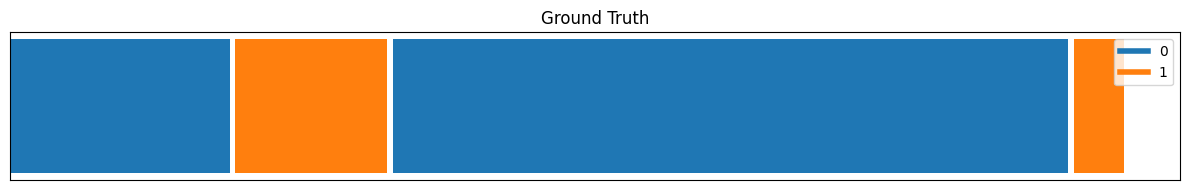

In [52]:
path = os.path.join("/home/nadir/tmr-code/archive/samples/", np.random.choice(os.listdir("/home/nadir/tmr-code/archive/samples/")))

hml3d_sample = np.load(path, allow_pickle=True).item()

print("[hml3d_sample.keys()]:", hml3d_sample.keys())

sample = {
    "motion": torch.tensor(hml3d_sample["transformed_motion"], dtype=torch.float32).to(device),
    "transformed_motion": torch.tensor(hml3d_sample["motion"], dtype=torch.float32).to(device),
}

outputs, exception = model.segment_sequence(
    sample,
    window_size=window_size,
    window_step=1,
    mean=mean,
    std=std
)

if exception is not None:
    logger.warning(f"[skipped-sequence]: {path} due to {exception}")

print("[outputs.shape]:", outputs.shape)

preds = outputs.cpu().numpy()

print("[annotations]:", hml3d_sample["annotations"])

import matplotlib.pyplot as plt
from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.utils import (
    frame_level_annotations_to_segment_level_annotations,
)

visualizer = SegmentationVisualizer(labels_values=[0, 1])

visualizer.plot_segmentation(preds, header="Ground Truth", fps=20, show_ticks=False)
plt.show()